In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 - Import the libraries

In [ ]:
import os
from glob import glob

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# 2 - Load the data, create the train, validation and test datasets, and show some sample images

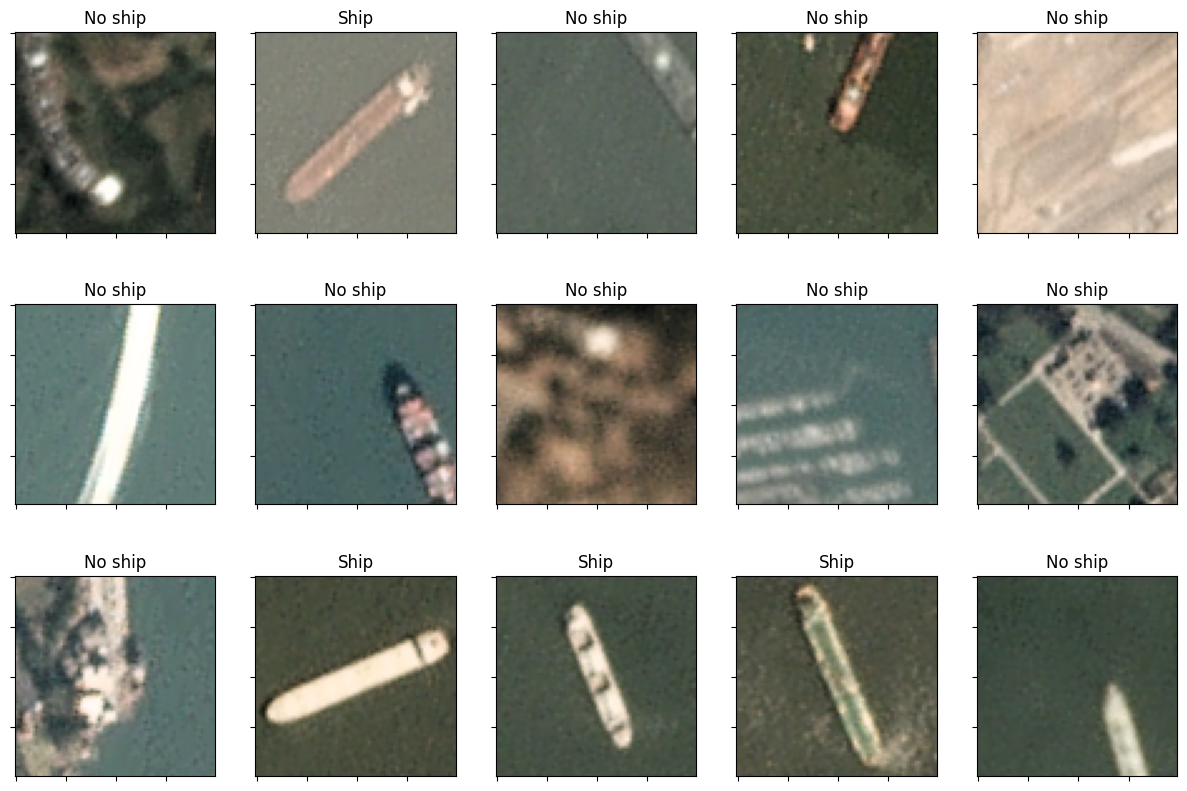

In [ ]:
# Set basepath
basepath = "/content/drive/MyDrive/Dataset/archive/shipsnet/shipsnet"

# Generate a list of files for ship and no_ship files
files_list_no_ship = glob(os.path.join(basepath, "0_*"))
files_list_ship = glob(os.path.join(basepath, "1_*"))

# Open the files
images = []
labels = []
text_labels = ['No ship', 'Ship']

for file in files_list_no_ship:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(0)

for file in files_list_ship:
    img_path = os.path.join(basepath, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(1)

images = np.array(images, dtype=np.int64)
labels = np.array(labels, dtype=np.int64)

# Split the data into train (70%), validation (20%) and test (10%) datasets
np.random.seed(27)
np.random.shuffle(images)

np.random.seed(27)
np.random.shuffle(labels)

train = int(0.7*len(images))
validation = int(0.2*len(images))
test = int(0.1*len(images))

X_train, y_train = images[:train], labels[:train]
X_validation, y_validation = images[train:(validation+train)], labels[train:(validation+train)]
X_test, y_test = images[(validation+train):], labels[(validation+train):]

n_classes = 2

# Change the labels from categorical to one-hot encoding, i.e., class '1' transforms into vector [0, 1]
y_train = to_categorical(y_train, n_classes)
y_validation = to_categorical(y_validation, n_classes)
y_test = to_categorical(y_test, n_classes)

# Plot some sample images
n_rows = 3
n_cols = 5

plt.figure(figsize=(15, 10))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    index = random.randint(0, len(X_train) - 1)
    plt.imshow(X_train[index])
    plt.title(text_labels[np.argmax(y_train[index])])

In [ ]:
import pandas as pd
import json

# Load the JSON file
with open('/content/drive/MyDrive/Dataset/archive/shipsnet.json') as f:
    data = json.load(f)

# Convert JSON to DataFrame if it's structured as a list of dictionaries
metadata = pd.json_normalize(data)
print(metadata.head())
print(metadata.info())


                                                data  \
0  [[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, ...   

                                              labels  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                           locations  \
0  [[-118.2254694333423, 33.73803725920789], [-12...   

                                           scene_ids  
0  [20180708_180909_0f47, 20170705_180816_103e, 2...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       1 non-null      object
 1   labels     1 non-null      object
 2   locations  1 non-null      object
 3   scene_ids  1 non-null      object
dtypes: object(4)
memory usage: 160.0+ bytes
None


In [ ]:
# Expand the lists within each column to separate rows
expanded_df = pd.DataFrame({
    'data': metadata['data'].iloc[0],
    'labels': metadata['labels'].iloc[0],
    'locations': metadata['locations'].iloc[0],
    'scene_ids': metadata['scene_ids'].iloc[0]
})
print(expanded_df.head())

                                                data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007  


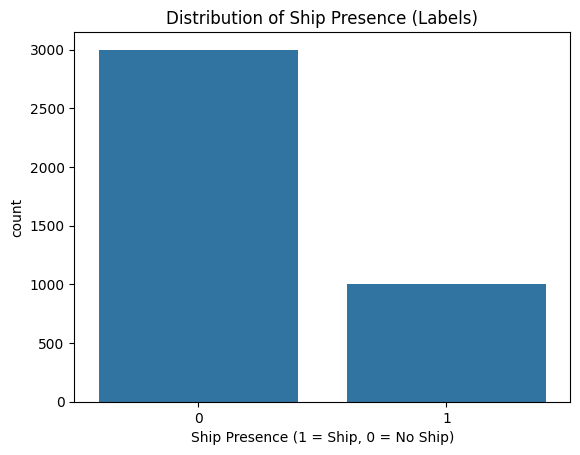

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='labels', data=expanded_df)
plt.title('Distribution of Ship Presence (Labels)')
plt.xlabel('Ship Presence (1 = Ship, 0 = No Ship)')
plt.show()


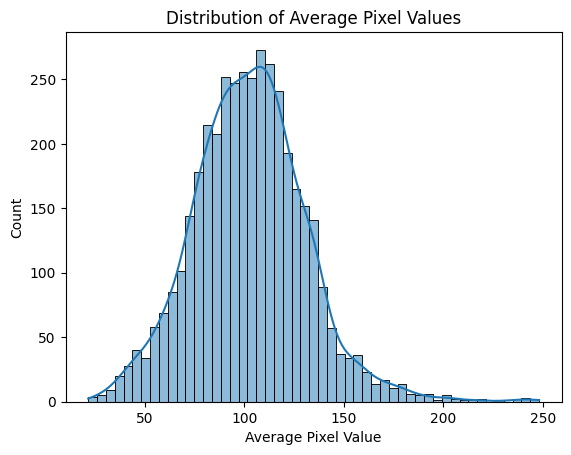

In [ ]:
import numpy as np

# Example: Calculate basic stats if `data` holds pixel values for each image scene
data_stats = expanded_df['data'].apply(lambda x: np.mean(x) if isinstance(x, list) else None)
sns.histplot(data_stats, kde=True)
plt.title('Distribution of Average Pixel Values')
plt.xlabel('Average Pixel Value')
plt.show()


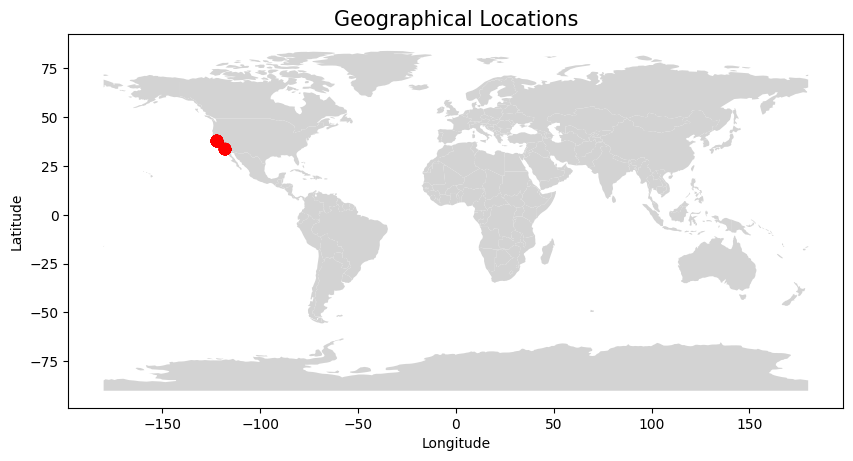

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Example locations (replace with your actual coordinates)
locations = expanded_df['locations']  # assuming 'expanded_df' contains your data

# Convert locations into Points for GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in locations]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometry)

# Load the world shapefile (replace the path with where you downloaded it)
world = gpd.read_file('/content/drive/MyDrive/Dataset/archive/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Plot the map
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')  # Draw the world map

# Plot the locations as red points
gdf.plot(ax=ax, color='red', markersize=50)

# Set plot title and labels
ax.set_title('Geographical Locations', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the map
plt.show()


# 3 - Define the Convolutional Neural Network

In [ ]:
# Define the Neural Network
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='linear', input_shape = (80, 80, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 80, 80, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 40, 40, 32)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 40, 40, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 64)       

# 4 - Compile and fit the model

In [ ]:
# Compile and fit the NN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("ship_detection.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, batch_size=16, epochs=40, verbose=1, validation_data=(X_validation, y_validation), callbacks=[checkpoint])

Epoch 1/40
175/175 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.8704
Epoch 1: val_accuracy improved from -inf to 0.88250, saving model to ship_detection.keras
175/175 [==============================] - 11s 49ms/step - loss: 0.3690 - accuracy: 0.8704 - val_loss: 0.3126 - val_accuracy: 0.8825
Epoch 2/40
175/175 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9168
Epoch 2: val_accuracy improved from 0.88250 to 0.93250, saving model to ship_detection.keras
175/175 [==============================] - 8s 46ms/step - loss: 0.2346 - accuracy: 0.9168 - val_loss: 0.2631 - val_accuracy: 0.9325
Epoch 3/40
174/175 [============================>.] - ETA: 0s - loss: 0.1537 - accuracy: 0.9429
Epoch 3: val_accuracy did not improve from 0.93250
175/175 [==============================] - 8s 47ms/step - loss: 0.1532 - accuracy: 0.9432 - val_loss: 0.1616 - val_accuracy: 0.9262
Epoch 4/40
174/175 [============================>.] - ETA: 0s - loss: 0.1136 - ac

# 5 - Evaluate the model

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

13/13 [==============================] - 1s 22ms/step - loss: 0.0876 - accuracy: 0.9800
Test Loss: 0.08758014440536499
Test Accuracy: 0.9800000190734863


# 6 - Show accuracy and loss plots of the model

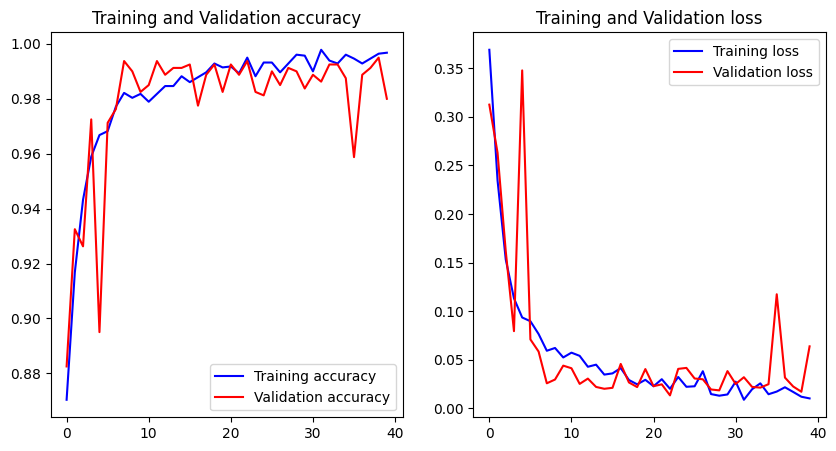

In [ ]:
# Show accuracy and loss plots of the model
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# 7 - Predict

In [ ]:
# Obtain predictions
predicted_class = model.predict(X_test)

predicted_class_probability = np.max(predicted_class, axis=1)*100
predicted_class = np.argmax(predicted_class, axis=1)
true_class = np.argmax(y_test, axis=1)

correct = []
incorrect = []

for i in range(len(predicted_class)):
    if predicted_class[i] == true_class[i]:
        correct.append(i)
    else:
        incorrect.append(i)

print('Correct predictions: ', len(correct))
print('Incorrect predictions: ', len(incorrect))

13/13 [==============================] - 0s 16ms/step
Correct predictions:  392
Incorrect predictions:  8


# 10 - Show Confussion Matrix

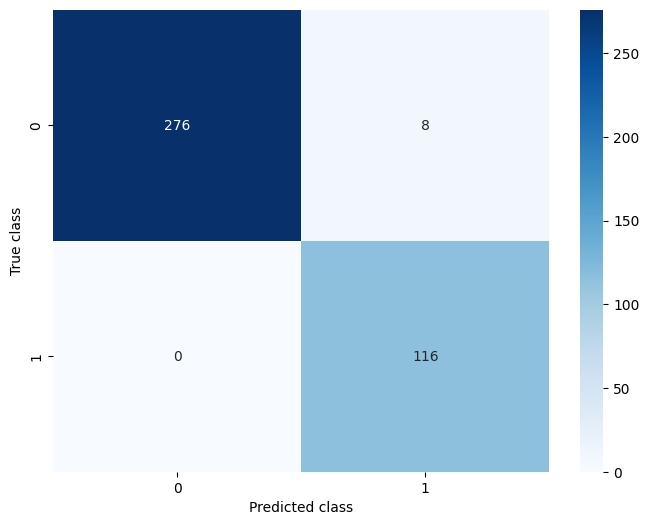

In [ ]:
# Show confussion Matrix
cm = confusion_matrix(true_class, predicted_class)
plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()